In [141]:
import pandas as pd
import re
import spacy
import PyPDF2
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import tqdm
from collections import Counter

In [61]:
BOOK_PATH = "./books/crime_punishment_book.pdf"
STOP_WORDS = set(stopwords.words('english'))


In [101]:

def clean_text(text, additional_stopwords=set()):
    all_stopwords = STOP_WORDS.union(additional_stopwords)
    words = text.translate(str.maketrans('', '', string.punctuation)).split()
    
    cleaned_words = [word for word in words if word.lower() not in all_stopwords and len(word) > 1]
    
    return ' '.join(cleaned_words)

def generate_word_cloud(text, title="Untitled"):

    cleaned_text = clean_text(text)
    wordcloud =WordCloud(width = 800, height = 400, background_color ='white').generate(cleaned_text)

    
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=16)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") 
    plt.show()


In [95]:
IMPORTANT_CHARACTERS = [
    "Rodion Romanovich Raskolnikov",  # The protagonist, a conflicted former student.
    "Sofya Semyonovna Marmeladov (Sonya)",  # A prostitute with a strong moral compass, Raskolnikov's love interest.
    "Dmitri Prokofych Razumikhin",  # Raskolnikov's cheerful and loyal friend.
    "Avdotya Romanovna Raskolnikov (Dunya)",  # Raskolnikov's proud sister.
    "Pulcheria Alexandrovna Raskolnikov",  # Raskolnikov’s concerned mother.
    "Arkady Ivanovich Svidrigailov",  # Dunya's former employer with a dark side.
    "Porfiry Petrovich",  # The astute investigator.
    "Katerina Ivanovna Marmeladov",  # Stepmother to Sonya, tragic figure.
    "Pyotr Petrovich Luzhin",  # Dunya's self-serving fiancé.
    "Semion Zakharovich Marmeladov",  # Sonya's alcoholic father.
    "Alyona Ivanovna",  # The old pawnbroker, victim of Raskolnikov's murder.
    "Lizaveta Ivanovna",  # Alyona Ivanovna’s half-sister, another victim.
    "Andrei Semyonovich Lebezyatnikov",  # Luzhin’s utopian socialist roommate.
    "Nastasya Petrovna",  # Housekeeper of Raskolnikov's apartment, often involved in key scenes.
    "Zossimov",  # A doctor and friend of Razumikhin, treats Raskolnikov.
    "Ilya Petrovich",  # A police official known for his temper.
    "Marfa Petrovna Svidrigailov",  # Svidrigailov's deceased wife, appears in flashbacks.
    "Amalia Ivanovna Ludvigovna",  # Landlady of the Marmeladovs, known for her querulous nature.
]


In [96]:

PAGES = []

def clean_text(text):
    # Replace non-breaking spaces and other non-ASCII characters
    text = re.sub(r'\xa0', ' ', text)  # Replace non-breaking spaces with normal spaces
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Replace any non-ASCII character with space
    return text

with open(BOOK_PATH, 'rb') as file:
    reader = PyPDF2.PdfReader(file)

    # Iterate over each page and extract text
    for page in reader.pages:
        text = page.extract_text()
        if text:
            cleaned_text = clean_text(text)
            PAGES.append(cleaned_text)

In [97]:
PAGES_BY_SECTIONS = [PAGES[i * 100 : (i + 1) * 100] for i in range(7)]

print([len(section) for section in PAGES_BY_SECTIONS])

[100, 100, 100, 100, 100, 100, 85]


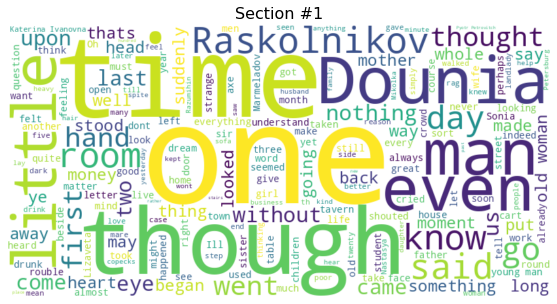

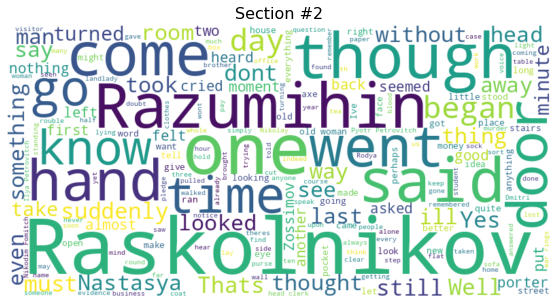

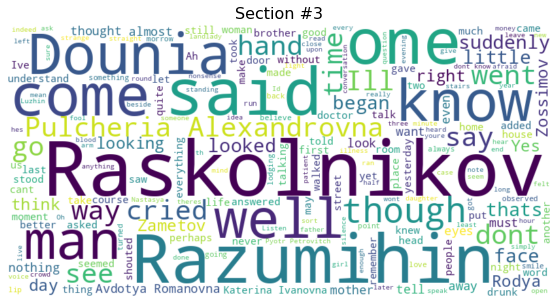

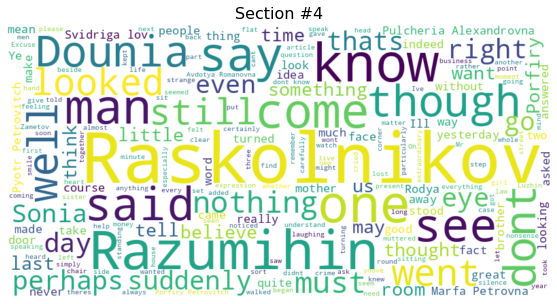

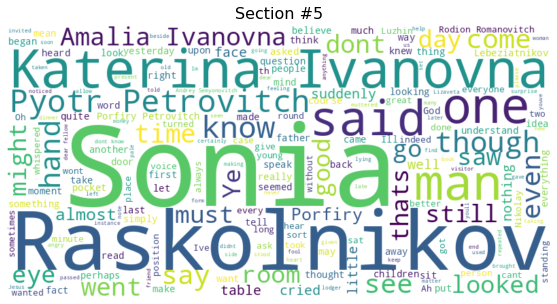

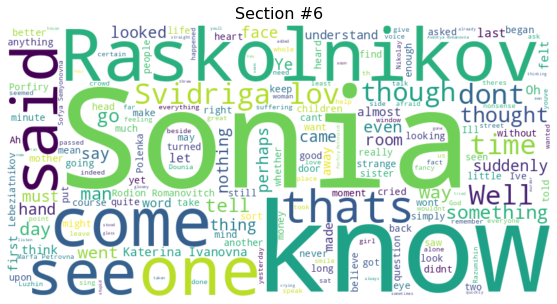

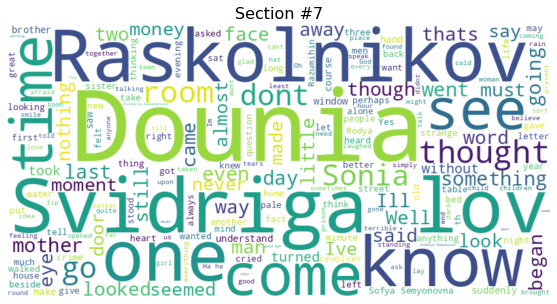

In [100]:
for i, section in enumerate(PAGES_BY_SECTIONS):
    generate_word_cloud("\n".join(section), title=f"Section #{i + 1}")

### Extract Entities from Pages



In [152]:
#!python3 -m spacy download en_core_web_sm 

In [105]:
nlp = spacy.load('en_core_web_sm')

In [107]:
nlp.component_names

['tok2vec',
 'tagger',
 'parser',
 'senter',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [131]:
doc = nlp(PAGES[50])

In [167]:
MENTIONS = []

MENTIONS_BY_PAGES = []

for i in tqdm.tqdm(range(len(PAGES))):
    
    doc = nlp(PAGES[i])

    doc_mentions = [ent.text  for ent in doc.ents if ent.label_ == "PERSON"]
    
    MENTIONS.extend(doc_mentions)
    MENTIONS_BY_PAGES.append(doc_mentions)

100%|█████████████████████████████████████████| 685/685 [01:00<00:00, 11.23it/s]


In [178]:

mentions_counter = Counter(MENTIONS)


mentions_counter.most_common()[:40]

[('Raskolnikov', 726),
 ('Sonia', 364),
 ('Katerina Ivanovna', 107),
 ('Pyotr Petrovitch', 86),
 ('Porfiry', 78),
 ('Pyotr', 57),
 ('Luzhin', 53),
 ('Avdotya Romanovna', 51),
 ('Razumihin', 51),
 ('Marfa Petrovna', 46),
 ('Porfiry Petrovitch', 45),
 ('Sofya Semyonovna', 37),
 ('Nastasya', 34),
 ('Dmitri', 30),
 ('Pulcheria Alexandrovna', 30),
 ('Katerina  Ivanovna', 29),
 ('Petrovitch', 29),
 ('Lizaveta', 25),
 ('Lebeziatnikov', 25),
 ('Amalia Ivanovna', 23),
 ('Lida', 22),
 ('Koch', 20),
 ('Marfa', 19),
 ('Petersburg', 16),
 ('Semyonovna', 16),
 ('Marmeladov', 15),
 ("Katerina Ivanovna's", 14),
 ('Ivanovna', 13),
 ('Katerina \nIvanovna', 12),
 ('Rodya', 12),
 ('Nikolay', 12),
 ('Dmitri Prokofitch', 12),
 ('Jesus', 12),
 ('Andrey Semyonovitch', 12),
 ('Alyona Ivanovna', 11),
 ('Svidriga', 11),
 ('Nikodim Fomitch', 11),
 ('Rodion Romanovitch', 11),
 ('Ilya Petrovitch', 10),
 ('Zossimov', 10)]

We certainly need to do some merging, since some of characters were named differenty in different context:

*e.g*: "Pyotr Petrovich", "Pyotr" and "Luzhin" are actually the same characters. As we don't have extremely large collection of characters, we can mannually merge and standardize the names in text.


###  Names standardization

In [203]:
NAME_MAPPING = {"Raskolnikov" : ['Rodion Romanovitch',
                                 'Rodya'],
                "Luzhin" : ['Pyotr',
                            'Pyotr Petrovitch',
                            'Petrovitch'],
                
               "Katerina Ivanovna" : [
                                      'Katerina \nIvanovna',
                                      'Ivanovna'],
               "Dmitri" : [
                           'Dmitri Prokofitch']}



def standardize_names(text, name_mapping):
    for standard_name, variations in sorted(name_mapping.items(), key=lambda x: -len(x[0])):
        escaped_variations = [re.escape(name).replace(r'\ ', r'\s+') for name in variations]
        pattern = r'\b(' + '|'.join(escaped_variations) + r')\b'
        text = re.sub(pattern, standard_name, text, flags=re.IGNORECASE)

    return text


def clean_entities(entities):
    cleaned_entities = []
    for entity in entities:
        # Split the entity by spaces and remove duplicates by converting to a set and back to list
        unique = ' '.join(sorted(set(entity.split()), key=entity.split().index))
        cleaned_entities.append(unique)
    return cleaned_entities



### Collecting mentions again

In [204]:
ST_MENTIONS = []

ST_MENTIONS_BY_PAGES = []

for i in tqdm.tqdm(range(len(PAGES))):

    st_text = standardize_names(PAGES[i], NAME_MAPPING)
    doc = nlp(st_text)

    doc_mentions = [ent.text  for ent in doc.ents if ent.label_ == "PERSON"]

    cleaned_mentions = clean_entities(doc_mentions)
    
    ST_MENTIONS.extend(cleaned_mentions)
    ST_MENTIONS_BY_PAGES.append(cleaned_mentions)

100%|█████████████████████████████████████████| 685/685 [01:00<00:00, 11.32it/s]


In [212]:

st_counter = Counter(ST_MENTIONS)

#filter entities that mentioned more than 10 times
MOST_COMMON_ENTITIES = [entity[0] for entity in st_counter.most_common() if entity[1] > 10]
print(MOST_COMMON_ENTITIES[:10])

#remove entities that are not common
FILTERED_MENTIONS_BY_PAGE = [ [ent for ent in page if ent in MOST_COMMON_ENTITIES] 
                             for page in ST_MENTIONS_BY_PAGES]


['Raskolnikov', 'Sonia', 'Katerina Ivanovna', 'Luzhin', 'Porfiry', 'Porfiry Luzhin', 'Avdotya Romanovna', 'Razumihin', 'Marfa Petrovna', 'Dmitri']


In [215]:
FILTERED_MENTIONS_BY_PAGE[:15]

[[],
 ['Petersburg'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Raskolnikov', 'Raskolnikov'],
 ['Raskolnikov', 'Lizaveta', 'Raskolnikov'],
 ['Katerina Ivanovna'],
 [],
 ['Raskolnikov', 'Raskolnikov'],
 []]